In [2]:
!pip3 install opencv-python


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: unyt 2.8.0 has a non-standard dependency specifier numpy>="1.13.0". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of unyt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import time
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras

2024-06-26 23:32:39.131667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cita/h/home-2/ajain/.local/lib/python3.10/site-packages/cv2/../../lib64:/cita/modules/python/3.10.2/lib
2024-06-26 23:32:39.131710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
# tells the python environemnt to only use the specified index of the gpu 
#to ensure that TensorFlow uses the specified GPU(s).


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
img_height, img_width = 256, 256
# setting image size
batch_size = 32
# setting the batch size 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/home/ajain/cloudphinder/image_data0_bound',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# the above function will extract image data from the specified directory


Found 859 files belonging to 1 classes.


2024-06-26 23:32:48.562470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cita/h/home-2/ajain/.local/lib/python3.10/site-packages/cv2/../../lib64:/cita/modules/python/3.10.2/lib
2024-06-26 23:32:48.562507: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-26 23:32:48.562548: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shrimp): /proc/driver/nvidia/version does not exist


2024-06-26 23:32:49.138596: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


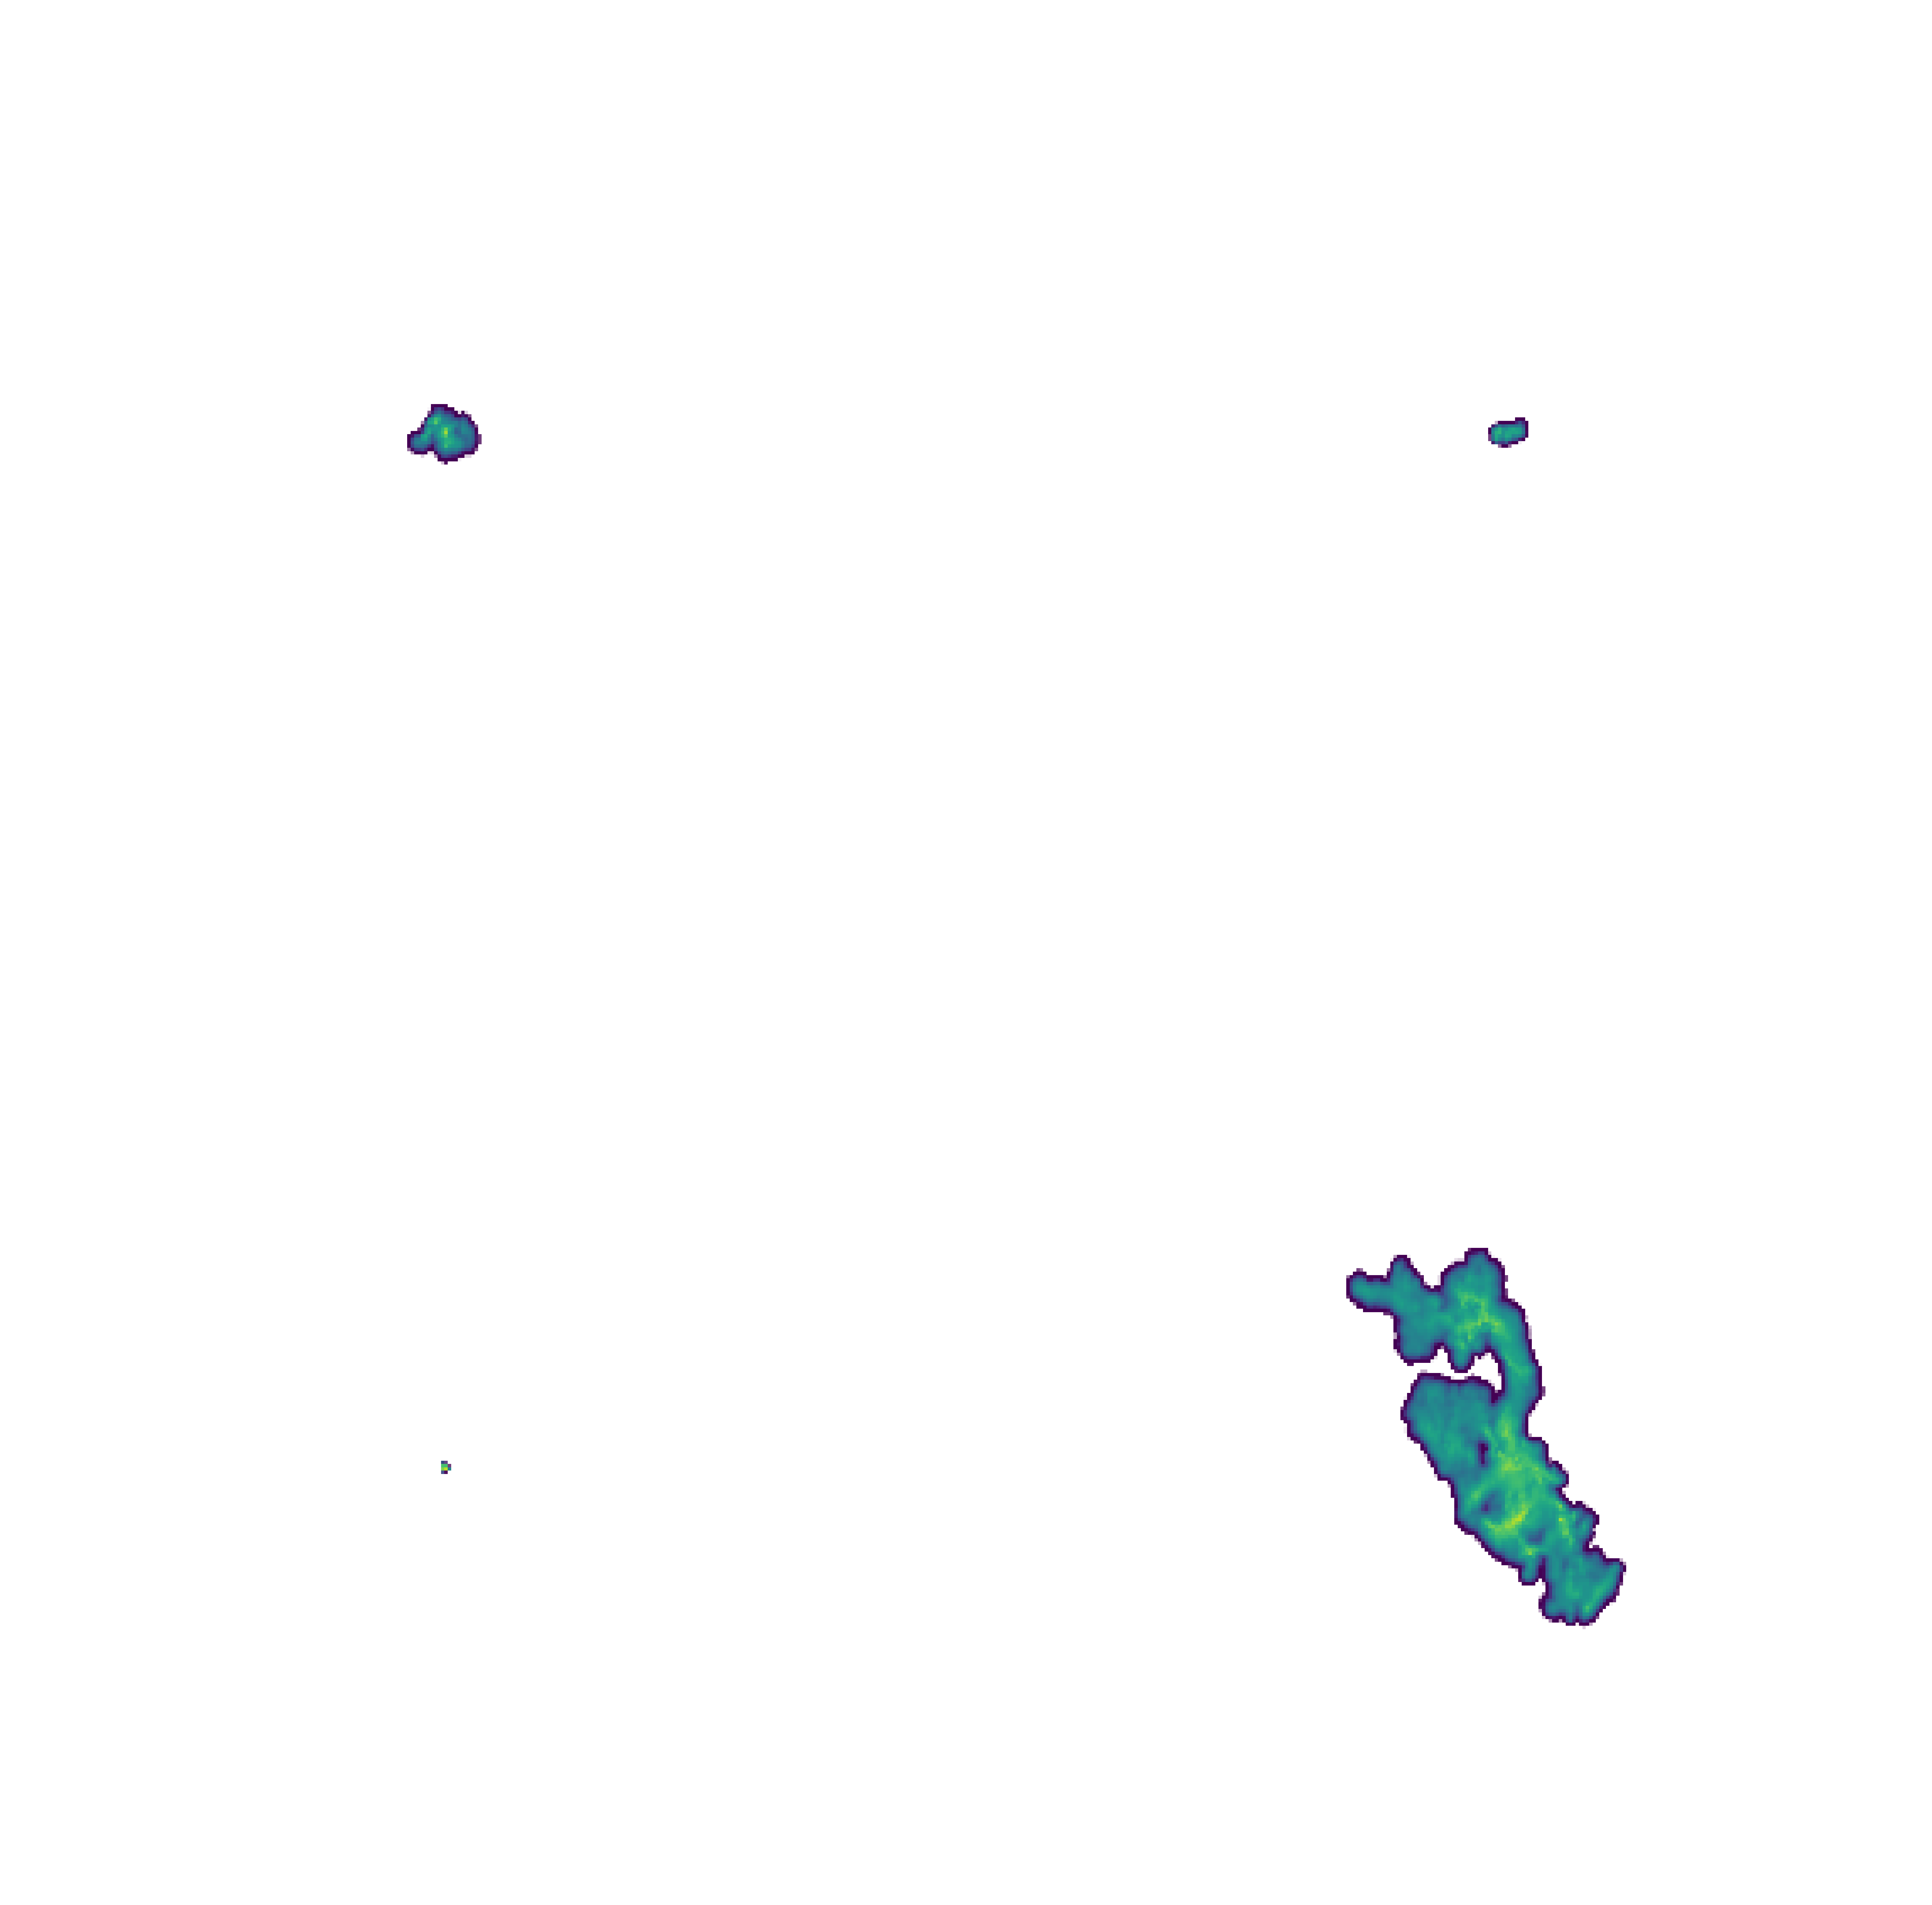

In [4]:
plt.figure(figsize=(100, 100))
for images in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [5]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(first_image.shape)
# this code has basically normalized the image array which earlier was in the form of a 3-d array where each element 
# represents one of the rgb values and each rgb values are in range of [0,1] after being normalized

(256, 256, 3)


2024-06-26 23:32:54.922152: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
def sampling_encoder(parameters):
    # this function handles the reparametrization trick and defines the posterior 
    # basically it tells the VAE how to sample the latent space from the approximate posterior q(z|x)
    # keras.shape(tensor) gives the row X column shape of the matrix
    mean, log_var= parameters
    seed= np.random.seed(42)
   # Sampling epsilon from N(0, 1) with shape matching mean
    epsilon= K.random_normal(shape=K.shape(mean),mean=0.,stddev=1.,seed= seed)
    # Reparameterization trick to sample z from q(z|x)
    z= mean + K.exp(log_var / 2) * epsilon
    return z

In [7]:
# our goal is to find how the latent space will learn a distribution from which if we sample z then  we can generate
# the data along the third dimension
input_encoder = tuple(first_image.shape)
# why are we creating a tuple of the shape of the first image if this is the input to the encoder- because here we are
# just defining the model not training it
input_decoder = (200,)
# in the encoder we have convolutional layers set to extract feature from the image 
# in the first layer we have set 32 filters to extract 32 features 

In [8]:
def encoder(input_encoder): # the input here are the surface-density images
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    x = layers.Dropout(0.2)(x)
   
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='relu_3')(x)
  
    # Block-4
    x = layers.Conv2D(32, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='tanh')(x)
 

    # Final Block
    # here we flattern the image to a latent space of 200 dimensions
    # we get a mean and log_var array that has 200 elements
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [9]:
enc = encoder(input_encoder)
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 128, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 bn_1 (BatchNormalization)      (None, 128, 128, 32  128         ['conv_1[0][0]']                 
                                )                                                           

In [10]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss_ =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss_

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred) # reconstruction loss calculated as mse-> reconstruction as we are caluclating E_q[log_p(p(x|z))]
    kl_loss_ = kl_loss(mean, log_var) # this is the loss that calculates how off p(z) and q(z|x) are( kl divergence between approx posetrior and prior)
    return  r_loss + kl_loss_
#ELBO= log(p(x))= E_q[log_p(p(x|z))]- E_q[log(q(z|x)/p(z))]-> we want to find q(z|x) and p(x|z) the latent distribution and the generative distribution


In [11]:
# this function defines the mean and log variance parameter that are paramters of our multivariate gaussian 
# this is input to the sampling_encoder function which returns the estimate for z the latent space sampled from q(x|z)
def sampling(input_1,input_2):
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    #The Lambda layer in Keras allows you to wrap arbitrary expressions as a Layer object. 
    #This is useful for implementing custom computations within the Keras functional API.
    # we use the lambda function to use the sampling_encoder
    out = layers.Lambda(sampling_encoder, name='encoder_output')([mean, log_var])
    # this function basically describes the model where a multivariate gaussian's parameters are the input and the output 
    # is the approximation for z= z_mean+ log(sigma/2)*epsilon
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [12]:
input_1 = (200,)
input_2 = (200,)
final = sampling(input_1,input_2)

In [13]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)
    
    # Block-1
    x = layers.Conv2DTranspose(32, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
 
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2DTranspose(128, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model


In [14]:
dec = decoder(input_decoder)
dec.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 32)       18464     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 32)        128       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 32)        0         
                                                           

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [16]:
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss


In [17]:
os.makedirs('/home/ajain/cloudphinder/training_weights', exist_ok=True)
os.makedirs('/home/ajain/cloudphinder/image', exist_ok=True)

In [18]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('/home/ajain/cloudphinder/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('/home/ajain/cloudphinder/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('/home/ajain/cloudphinder/image/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

In [21]:
n_epoches=30
is_train=True
if is_train==True:
    train(normalized_ds, n_epoches)

2024-06-26 22:00:43.641921: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


NameError: in user code:

    File "/tmp/ipykernel_317409/1215463768.py", line 8, in train_step  *
        generated_images = dec(latent, training=True)

    NameError: name 'dec' is not defined


In [19]:
n_epoches=30
enc.load_weights('/home/ajain/cloudphinder/training_weights/enc_'+str(n_epoches-1)+'.h5')

In [20]:
n_epoches=30
dec.load_weights('/home/ajain/cloudphinder/training_weights/dec_'+str(n_epoches-1)+'.h5')

In [21]:
reconstruction_shape = 1000

In [22]:
embeddings = None
mean = None
var = None
for i in normalized_ds:
    m,v = enc.predict(i)
    embed = final.predict([m,v])
    #embed = dec.predict(latent)
    if embeddings is None:
        embeddings = embed
        mean = m
        var = v
    else:
        embeddings = np.concatenate((embeddings, embed))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if embeddings.shape[0] > reconstruction_shape:
        break

1/1 [==============================] - 0s 59ms/step


/cita/modules/python/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


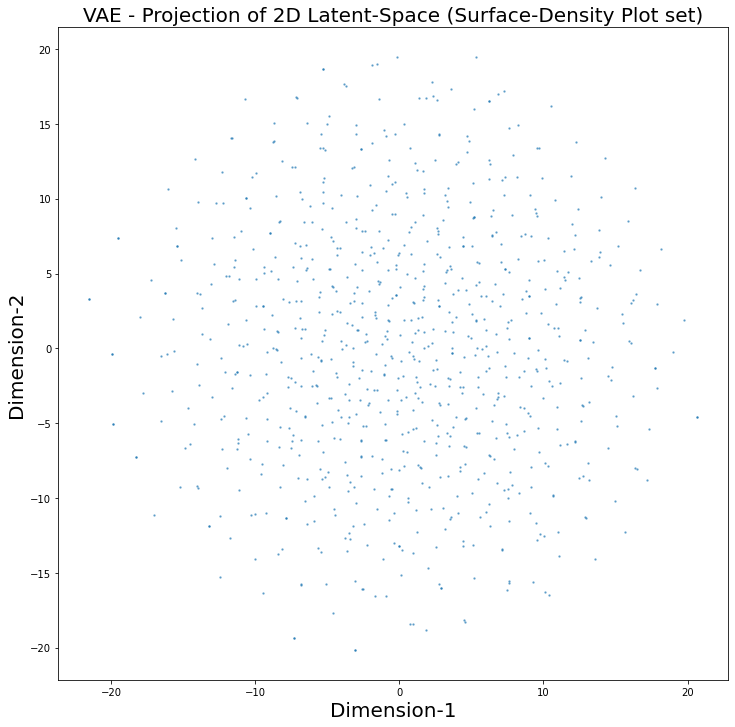

In [27]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate=100)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("VAE - Projection of 2D Latent-Space (Surface-Density Plot set)", size=20)
plt.show()